# Wildfire Analysis

The goal of this project is to be able to inform policy makers, government bodies, to make an informed plan for how they could or whether they should make plans to mitigate future impacts from wildfires. 
For this project, we will be analyzing wildfire impacts in Wichita City, Kansas State. 

## Part 1: Common Analysis

The wildfire dataset we are working with is obtained from the [ScienceBase-Catalog](https://www.sciencebase.gov/catalog/item/61aa537dd34eb622f699df81).
We download the GeoJSON Files.zip and will be working with the USGS_Wildland_Fire_Combined_Dataset.json file.

The following code used to parse the json file is adapted from the code example was developed by Dr. David W. McDonald for use in DATA 512, a course in the UW MS Data Science degree program. [wildfire_geo_prxoimity_example.ipynb](../example_notebooks/wildfire_geo_proximity_example.ipynb)

We start by importing all libraries that are needed to run this module.

In [6]:
import os, json, time
#
#    The module pyproj is a standard module that can be installed using pip or your other favorite
#    installation tool. This module provides tools to convert between different geodesic coordinate systems
#    and for calculating distances between points (coordinates) in a specific geodesic system.
#
from pyproj import Transformer, Geod
#
#    The 'wildfire' module is a user module. This module is available from the course website. The module
#    includes one object, a Reader, that can be used to read the GeoJSON files associated with the
#    wildefire dataset. The module also contains a sample datafile that is GeoJSON compliant and that
#    contains a small number of California wildfires extracted from the main wildfire dataset.

#    There is a GeoJSON reader that you might try if you wanted to read the data. It has its own quirks.
#    There will be an example below that reads the sample file "Wildfire_short_sample.json"
#    
import geojson
import pandas as pd
import csv
import matplotlib.pyplot as plt
import numpy as np

from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error


I modified Dr. McDonald's codes and used a file path directly, instead of using PythonPath. 

In [2]:
FILENAME = "C:/Users/fioyu/Desktop/UW/DATA512/Project/data-512-project/wild_fire_data/USGS_Wildland_Fire_Combined_Dataset.json"
CITY_LOCATIONS = {
    "wichita": {"city": "Wichita",
        "latlon": [37.6889, -97.3360]}
}

In [3]:
print(f"Attempting to open '{FILENAME}'")
geojson_file = open(FILENAME,"r")
print(f"Using GeoJSON module to load sample file '{FILENAME}'")
gj_data = geojson.load(geojson_file)
geojson_file.close()

gj_keys = list(gj_data.keys())
print("The loaded JSON dictionary has the following keys:")
print(gj_keys)
print()

Attempting to open 'C:/Users/fioyu/Desktop/UW/DATA512/Project/data-512-project/wild_fire_data/USGS_Wildland_Fire_Combined_Dataset.json'
Using GeoJSON module to load sample file 'C:/Users/fioyu/Desktop/UW/DATA512/Project/data-512-project/wild_fire_data/USGS_Wildland_Fire_Combined_Dataset.json'
The loaded JSON dictionary has the following keys:
['displayFieldName', 'fieldAliases', 'geometryType', 'spatialReference', 'fields', 'features']



The instructions states that our estimate should only consider the last 60 years of wildland fire data (1961-2021). However, intuitively, we should be using the data from 1964-2024. Therefore, I decided to filter for data between 1961 - 1964 and I decided it would be easier to trim down, opposed to needing the whole chunk again. (It takes 1 - 1.5 hours)
I did also notice that there was no more data after 2020, thus I think it would make sense to include data from 1961. 


We are only interested in the features key, the corresponding value is a list of the observations.

In [4]:
filtered_features = [feature for feature in gj_data["features"] if feature["attributes"]["Fire_Year"] >= 1961 and feature["attributes"]["Fire_Year"] <=2024]

In [5]:
len(filtered_features)

118500

Examind the following structure, the important data/ intersting data that I would like to keep from the "attributes" key are "Fire_Year", "Listed_Fire_Names", "GIS_Acres", and "Assigned_Fire_Type". I considered using "Listed_Fire_Types", but there some fires had multiple labels, and I decided "Assigned_Fire_Type" would be a better estimate of the fire.

In [ ]:
gj_data["features"][0]

The two functions below are needed to calculate the average distance from place to fire perimeter. 
For each wildfire, we first convert their coordinates to a ring, and use it to calculate the average distance from our longitude latitude for Wichita, Kansa to the fire perimeter. 
To convert the ring, I added a statement to check if the length of *coord* is 2. In general the format of ring_data is a list of lists. However, I did realize a few entries where it was a dictionary, where the value is list of lists. For the purpose of this project, I have decided to ignore that points as I am unsure if they mean the same thing. 

In [7]:
def convert_ring_to_epsg4326(ring_data=None):
    converted_ring = list()
    #
    # We use a pyproj transformer that converts from ESRI:102008 to EPSG:4326 to transform the list of coordinates
    to_epsg4326 = Transformer.from_crs("ESRI:102008","EPSG:4326")
    # We'll run through the list transforming each ESRI:102008 x,y coordinate into a decimal degree lat,lon
    for coord in ring_data:
        if len(coord) == 2:
            lat,lon = to_epsg4326.transform(coord[0],coord[1])
            new_coord = lat,lon
            converted_ring.append(new_coord)
    return converted_ring

In [8]:
def average_distance_from_place_to_fire_perimeter(place=None,ring_data=None):
    # convert the ring data to the right coordinate system
    ring = convert_ring_to_epsg4326(ring_data)    
    # create a epsg4326 compliant object - which is what the WGS84 ellipsoid is
    geodcalc = Geod(ellps="WGS84")
    # create a list to store our results
    distances_in_meters = list()
    # run through each point in the converted ring data
    for point in ring:
        # calculate the distance
        d = geodcalc.inv(place[1],place[0],point[1],point[0])
        distances_in_meters.append(d[2])
    #print("Got the following list:",distances_in_meters)
    # convert meters to miles
    distances_in_miles = [meters*0.00062137 for meters in distances_in_meters]
    # the esri polygon shape (the ring) requires that the first and last coordinates be identical to 'close the region
    # we remove one of them so that we don't bias our average by having two of the same point
    distances_in_miles_no_dup = distances_in_miles[1:]
    # now, average miles
    # PROBLEM: DIVISION BY ZERO!!!!!
    if len(distances_in_miles_no_dup)!= 0:
        average = sum(distances_in_miles_no_dup)/len(distances_in_miles_no_dup)
    else:
        return None
    return average



In the following cell, we calculate the distance for each fire, and keep the 4 attributes discussed above(Fire_Year, Listed_Fire_Names, GIS_Acres, Assigned_Fire_Type) and save it as a dataframe. 

In [ ]:
place = CITY_LOCATIONS["wichita"]
# idx = 0
rows = []
for wf_feature in filtered_features:
    # Unncomment the prin(idx) and related rows for debugging. 
    # print(idx)
    wf_year = wf_feature["attributes"]["Fire_Year"]
    wf_name = wf_feature["attributes"]["Listed_Fire_Names"].split(',')[0]
    wf_size = wf_feature["attributes"]["GIS_Acres"]
    wf_type = wf_feature["attributes"]["Assigned_Fire_Type"]
    # wf_type = wf_feature["attributes"]["Listed_Fire_Types"]
    if 'rings' in wf_feature["geometry"]:
        ring_data = wf_feature["geometry"]["rings"][0]
    elif 'curveRings' in wf_feature["geometry"]:
        ring_data = wf_feature["geometry"]["curveRings"][0]
    else:
        raise Exception("HEY! No compatible geometry in this fire data!!!")

    #     Compute using the average distance to all points on the perimeter
    distance = average_distance_from_place_to_fire_perimeter(place['latlon'],ring_data)
    # print(f"Fire '{wf_name}' ({wf_size:1.2f} acres) from {wf_year} was an average {distance:1.2f} miles to {place['city']}")
    # just get a location to print thats on the ring (perimeter)
    ring = convert_ring_to_epsg4326(ring_data)
    perimeter_start = ring[0]
    # idx +=1
    new_row = {
        "Year": wf_year,
        "Acres": wf_size,
        "Distance": distance,
        "Fire_Type":wf_type
    }
    rows.append(new_row)
wildfire_df = pd.DataFrame(rows)
    # print(f"\tOne perimiter point lat,lon {perimeter_start[0]},{perimeter_start[1]}")


We print the first 5 rows of the wildfire data to examine. 

In [21]:
wildfire_df.head(5)

,Year,Acres,Distance,Fire_Type
0,1961,55249.740141,1336.026693,Wildfire
1,1961,43920.841077,1225.881051,Wildfire
2,1961,34233.698603,1276.446979,Wildfire
3,1961,32866.053451,1323.039261,Wildfire
4,1961,27269.045936,1243.502757,Wildfire


Then we save the results as a csv file.

In [2]:
wildfire_df.to_csv("../intermediate_data/wildfire.csv", index=False)

## Smoke Estimate

In [7]:
wildfire_df =  pd.read_csv("../intermediate_data/wildfire.csv")

For part 1 of this project, we are estimating wildfire smoke impacts in Wichita Kansas for the most recent 60 years of wildfire data. Throughout this project, we will incorporate other considerations such as health, economic or other social problems that result from the smoke. 
Therefore, we will start part 1 with a generic *wildfire smoke imapct* which represents an estimate of the smoke Wichita saw during each annual fire season.  <br>
The estimate is based on the following conditions:
1. The estimate only considers the last 60 years of wildland fire data (1961-2021).
2. The estimate only considers fires that are within 650 miles of your assigned city. 
3. Defines the annual fire season as running from May 1st through October 31st. 

Given the data we retried is between 1961-2024, we first need to filter for the wildfire_df for the specific dates and distance.   

In [8]:
filtered_wildfire_df = wildfire_df[
    (wildfire_df["Year"] >= 1961) & 
    (wildfire_df["Year"] <= 2021) & 
    (wildfire_df["Distance"] <= 650)
].reset_index()

We examine the Fire_Type column to see if we can use it in our smoke estimate.

In [9]:
filtered_wildfire_df["Fire_Type"].unique()

array(['Wildfire', 'Unknown - Likely Wildfire', 'Prescribed Fire',
       'Likely Wildfire', 'Unknown - Likely Prescribed Fire'],
      dtype=object)

Here, we're assigning weights to the different fire types. Since prescribed fires are carried out under controlled conditions, and at lower intensities with optimal cnditions (eg: high humidty, lower winds), we assign prescribed fires with a lower weight.

In [10]:
fire_type_weights = {
    "Wildfire": 1.0,
    "Likely Wildfire": 0.8,
    "Prescribed Fire": 0.4,
    "Unknown - Likely Wildfire": 0.6,
    "Unknown - Likely Prescribed Fire": 0.2
}

In [11]:
filtered_wildfire_df["Fire_Weight"] = filtered_wildfire_df["Fire_Type"].map(fire_type_weights)

We know that smoke is generally dependent on the wind patterns, acres burnt, the distance from the fire, and intensity of fire.
For this project, we only know the acres burnt, the distance from the wildfire, and whether it's a wildfire.
We know that the more acres burnt, the more smoke we expect. Similarly, the further the distance, the less smoke we expect. 
Putting these information together, we use the following equation to estimate smoke:

Smoke Density = k * Areas/(Distance^2) 
where k is a constant.  <br>
For the data available, we will calculate estimate smoke with Area/Distance^2.

In [12]:
filtered_wildfire_df["Estimated_Smoke"] =  (filtered_wildfire_df["Acres"] / (filtered_wildfire_df["Distance"]**2))

The graph below shows the average wildifre impact from wildfires over the years. I was curious what it would look like.

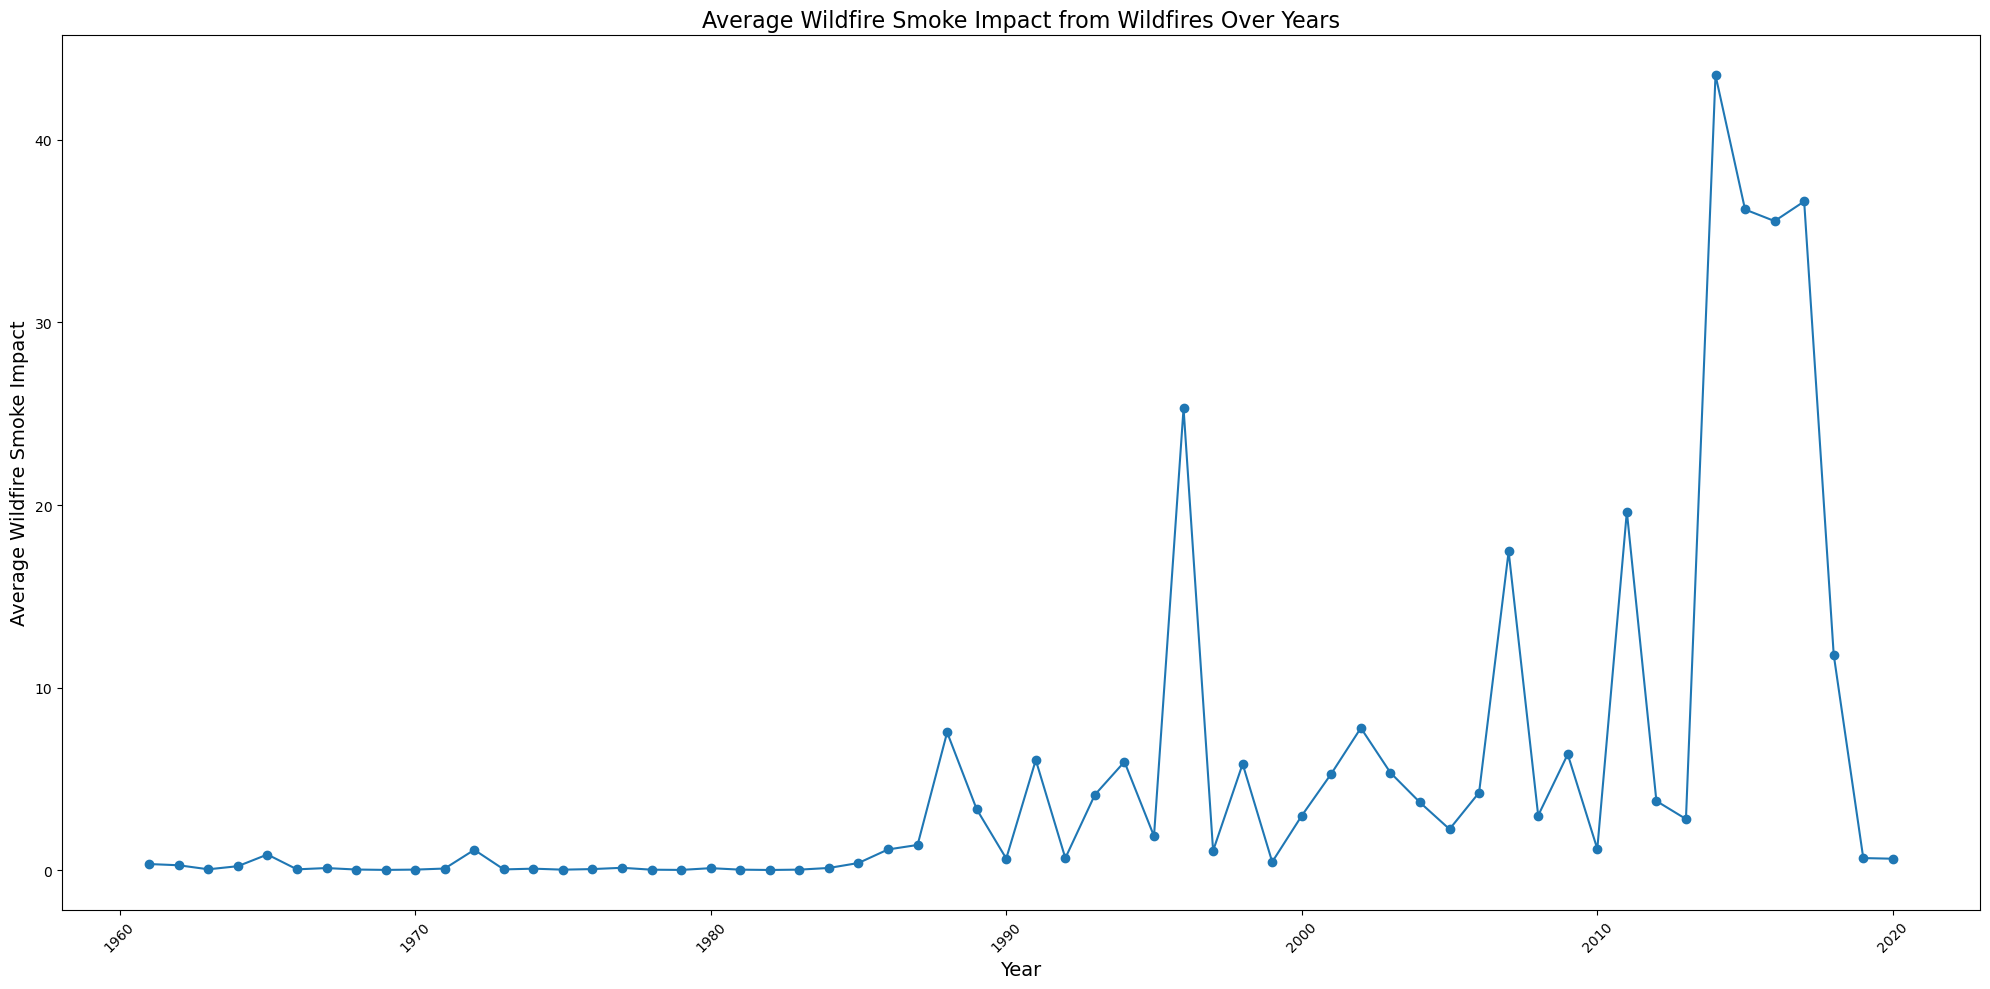

In [23]:
average_smoke_per_year = (filtered_wildfire_df.groupby("Year")["Estimated_Smoke"].mean().reset_index() )
average_smoke_per_year["Estimated_Smoke"] *= 100
average_smoke_per_year.columns = ["Year", "Average_Estimated_Smoke"]

plt.figure(figsize=(20, 10))
plt.plot(average_smoke_per_year["Year"], average_smoke_per_year["Average_Estimated_Smoke"], marker="o", linestyle="-")

plt.title("Average Wildfire Smoke Impact from Wildfires Over Years", fontsize=16)
plt.xlabel("Year", fontsize=14)
plt.ylabel("Average Wildfire Smoke Impact", fontsize=14)

plt.grid(False)

plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

Now, we are trying to create a model which can predict smoke impacts. 
Since we have mapped the fire type to a weight, we can drop the column to fit the model

In [14]:
wildfire_df_model = filtered_wildfire_df.drop(columns= "Fire_Type")

Using Sci-kit learn, I created the model, found the mean squared errors and printed the coefficients. 
We drop the Estimated_Smoke column so it is not considered in the model.

In [15]:
X = wildfire_df_model.drop(columns=["Estimated_Smoke","index"])
y = wildfire_df_model["Estimated_Smoke"]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

model = LinearRegression()
model.fit(X_train, y_train)

y_pred = model.predict(X_test)
mse = mean_squared_error(y_test, y_pred)

print(f"Mean Squared Error: {mse}")
print("Coefficients:", model.coef_)
print(model)


Mean Squared Error: 14.891129237744945
Coefficients: [-9.31344380e-04  8.11051005e-05 -8.99060126e-04 -2.77600493e-01]
LinearRegression()


In the next cell, we create a prediction_df dataframe to observe if the values for predicted_smoke makes sense.   
Since we are using a simple model, and there are limited variables we are considering, we don't expect the model to be super accurate.   
From the dataframe below, we can see the predicted smoke is generally under estimate smoke, and has negative values.
Negative smoke density does not make sense, for the sake of this project we use a simple log transformation and us the absolute value.   
While we will keep the model as it is for now, we recognize that there are other transformations that can be applied to improve predictions. For example, we could consider transformations on the input variables, or we could implement constraints to ensure that predicted_smoke values remain non-negative.

In [16]:
predictions_test_df = pd.DataFrame(X_test, columns=X.columns)  
predictions_test_df["Predicted_Smoke"] = y_pred 
predictions_test_df["Actual_Smoke"] = y_test.values  # This is our calculated smoke density.

predictions_test_df.reset_index(drop=True, inplace=True)
predictions_test_df['Predicted_Smoke'] = np.log1p(predictions_test_df['Predicted_Smoke']).abs()
predictions_test_df

,Year,Acres,Distance,Fire_Weight,Predicted_Smoke,Actual_Smoke
0,2014,3.664355,489.055939,1.0,0.173072,0.000015
1,2010,1063.257138,498.230548,0.4,0.085308,0.004283
2,1985,20.141572,259.578387,1.0,0.073006,0.000299
3,2014,900.316700,258.097183,0.4,0.253096,0.013515
4,2011,0.361432,312.354751,1.0,0.002465,0.000004
...,...,...,...,...,...,...
5204,2014,1395.606852,45.062189,0.2,0.454400,0.687288
5205,2016,1730.203039,266.466954,0.4,0.297083,0.024367
5206,2019,142.751318,500.205331,1.0,0.177123,0.000571
5207,2008,635.411274,494.769798,0.4,0.057633,0.002596


Now, we create a similar dataframe where we apply the train model on the entire dataset (wildfire_df_model) so we can use it for visualization

In [17]:
y_full_pred = model.predict(X)
predictions_full_df = pd.DataFrame(X, columns=X.columns)  
predictions_full_df["Predicted_Smoke"] = y_full_pred  
predictions_full_df.reset_index(drop=True, inplace=True)
predictions_full_df['Predicted_Smoke'] = np.log1p(predictions_full_df['Predicted_Smoke']).abs()

Lastly, we create a mock data to predict smoke estimates for every year for the next 25 years (2025-2050).
To be realistic, I randomly sample the Acres, Distance, and Fire_Weight from the data in 

In [ ]:
future_years = list(range(2025, 2051))
future_data = pd.DataFrame({'Year': future_years})

future_data['Acres'] = [wildfire_df_model['Acres'].sample(random_state=i).values[0] for i in range(len(future_years))]
future_data['Distance'] = [wildfire_df_model['Distance'].sample(random_state=i).values[0] for i in range(len(future_years))]
future_data['Fire_Weight'] = [wildfire_df_model['Fire_Weight'].sample(random_state=i).values[0] for i in range(len(future_years))]

future_predictions = model.predict(future_data)

future_predictions_df = future_data.copy()
future_predictions_df['Predicted_Smoke'] = future_predictions

future_predictions_df['Predicted_Smoke'] = np.log1p(future_predictions_df['Predicted_Smoke']).abs()

The table below shows the predicted smoke from 2025 to 2050.

In [ ]:
future_predictions_df

,Year,Acres,Distance,Fire_Weight,Predicted_Smoke
0,2025,28.896474,467.456869,0.8,0.096712
1,2026,186.802189,460.200050,0.4,0.036581
2,2027,41.438765,263.630803,0.4,0.183375
3,2028,9.664604,466.084767,0.4,0.015615
4,2029,9.047298,542.932660,1.0,0.249609
5,2030,4.833127,601.076130,1.0,0.320815
6,2031,4.855309,648.310249,1.0,0.382489
7,2032,39.796517,500.662900,1.0,0.202351
8,2033,11.209379,163.234230,0.4,0.249581
9,2034,5345.289182,397.508684,0.2,0.444731


# Visualization

## Graph 1

We start by calculating the number of fires every 50 miles. We save it to a dataframe under the "Number of Fires" column with a "Distance Range" column indicating the bin.

In [ ]:
fire_count_dict = {}
for lower in range(0, 1800, 50):
    upper = lower + 50

    count_fires = wildfire_df[(wildfire_df["Distance"] >= lower) & (wildfire_df["Distance"] < upper)].shape[0]
    fire_count_dict[f"{lower}-{upper}"] = count_fires

fires_count_within_distance = pd.DataFrame(list(fire_count_dict.items()), columns=["Distance Range", "Number of Fires"])


Table 1 below is a histogram which shows the number of Fires that occur every 50 miles from Kansas Wichita, ranging up to 1800 miles.   
After reviewing my data, I noticed there were no entries past 1650 miles.   
The red lines indicates 650 miles, which is the cut-off point for our model. 

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


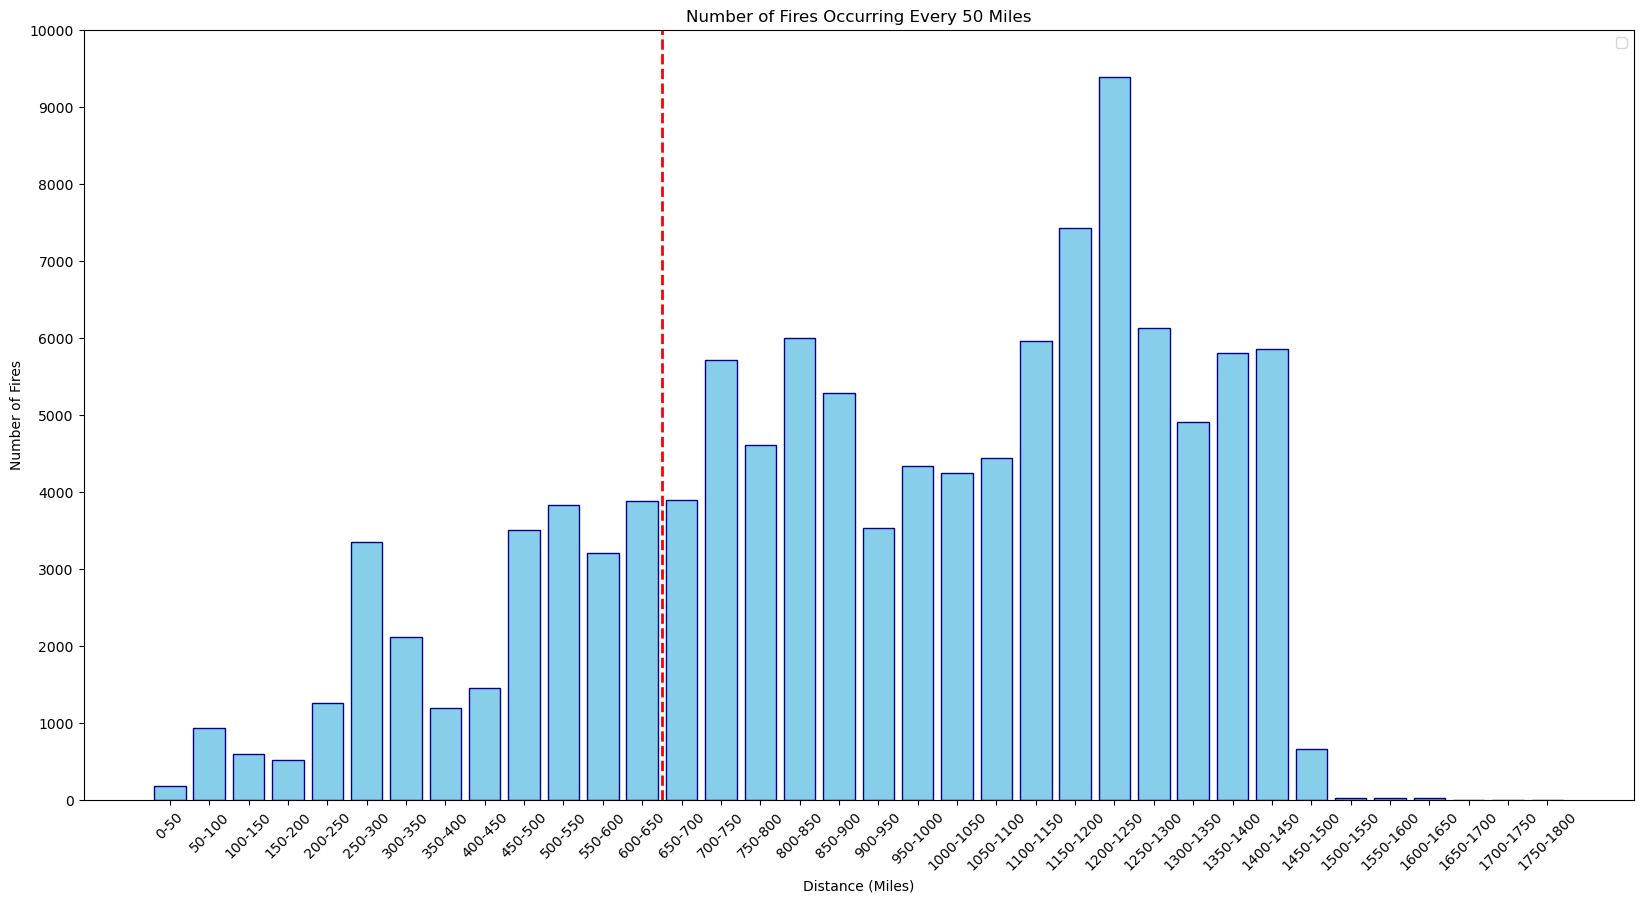

In [ ]:
counts = fires_count_within_distance["Number of Fires"]

plt.figure(figsize=(20, 10))
plt.bar(fires_count_within_distance["Distance Range"], counts, color="skyblue", edgecolor="darkblue")
plt.title("Number of Fires Occurring Every 50 Miles")
plt.xlabel("Distance (Miles)")
plt.ylabel("Number of Fires")

plt.yticks(range(0, max(counts) + 1000, 1000))
plt.xticks(rotation=45)

plt.axvline(x=12.5, color="red", linestyle="--", linewidth=2)
plt.legend()

plt.savefig("../graphs/num_fires_every_50_miles.png")
plt.show()

## Graph 2

Table 2 below is a time series graph of the total acres burned per year for the fires occuring 650 miles from Wichita, Kansas.  
We begin by filtering entries where "Distance" is less than or equal to 650 miles. 

In [ ]:
acres_burnt_per_year = (wildfire_df[wildfire_df["Distance"] <=  650]
                        .groupby("Year")["Acres"].sum().reset_index())

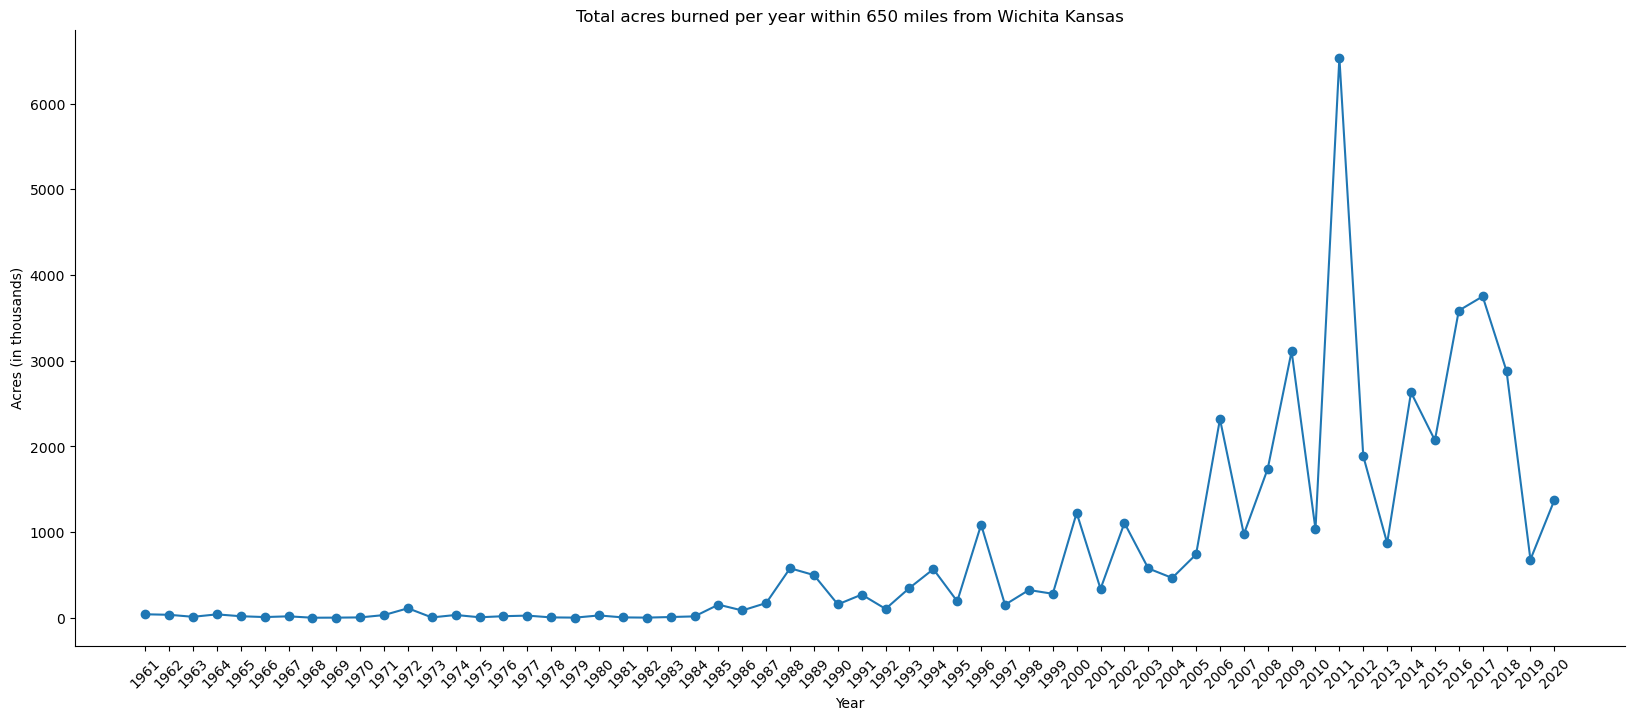

In [ ]:
plt.figure(figsize=(20, 8))
plt.plot(acres_burnt_per_year["Year"], acres_burnt_per_year["Acres"] / 1000, marker="o", linestyle="-")
plt.title("Total acres burned per year within 650 miles from Wichita Kansas")
plt.xlabel("Year")
plt.ylabel("Acres (in thousands)")  

plt.grid(False)

plt.xticks(acres_burnt_per_year["Year"], rotation=45)

plt.gca().spines["top"].set_visible(False)
plt.gca().spines["right"].set_visible(False)
plt.savefig("../graphs/acres_burned_per_year_max_650_miles.png")
plt.show()


Since the data was pretty flat from 1961-1983, I wanted to explore with different scales to see if I can find anything interesting.   
The graph below is the same,  just on a logarithmic scale.  
We can see that there is an overall upward trend, which is more consistent in recent years. After around 1990, there is a more stable fluctuations, I wonder if there were changes in fire reporting practices change causing this change. 

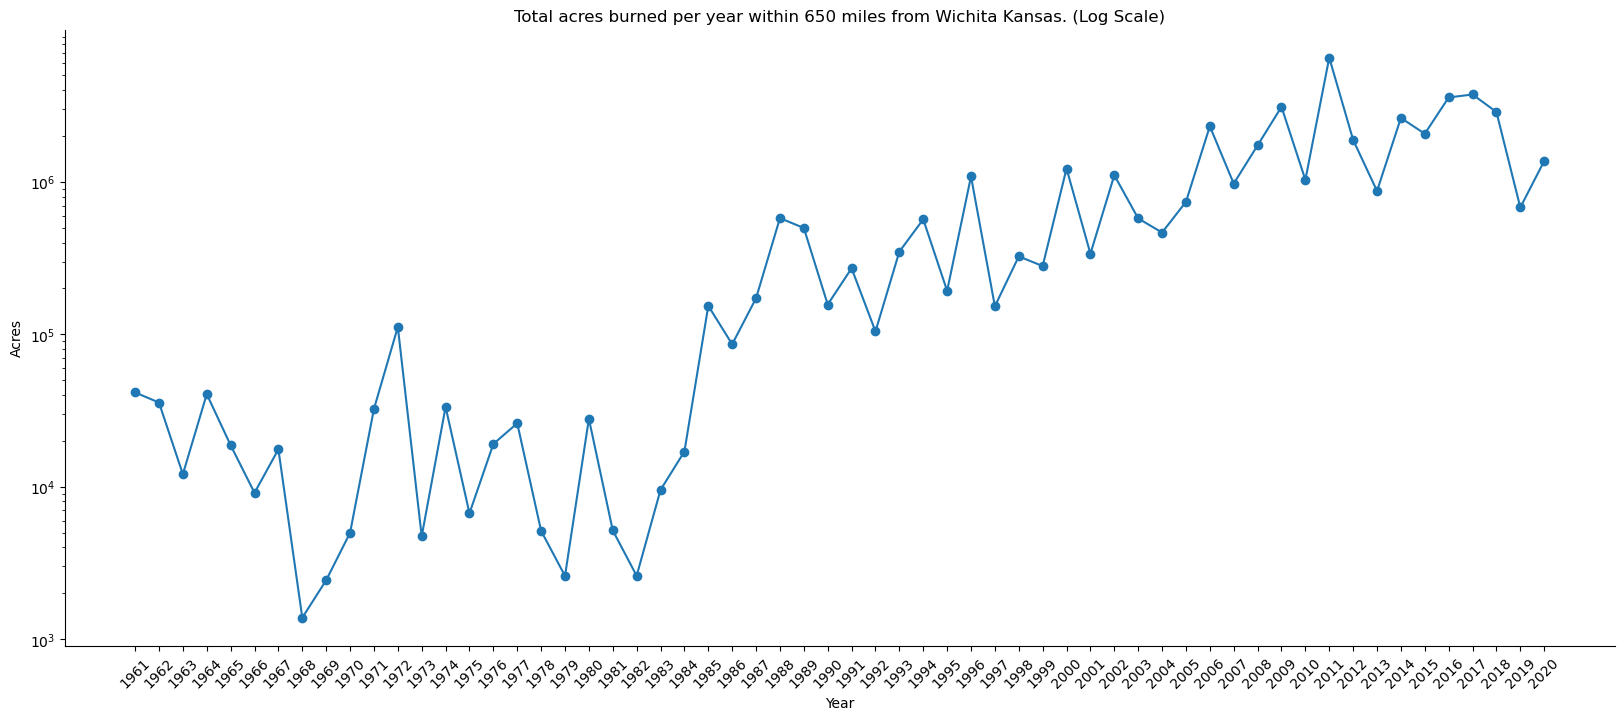

In [ ]:
plt.figure(figsize=(20, 8))
plt.plot(acres_burnt_per_year["Year"], acres_burnt_per_year["Acres"], marker='o', linestyle='-')
plt.title("Total acres burned per year within 650 miles from Wichita Kansas. (Log Scale)")
plt.xlabel("Year")
plt.ylabel("Acres")

plt.yscale("log")

plt.grid(False)
plt.xticks(acres_burnt_per_year["Year"], rotation=45)
plt.gca().spines["top"].set_visible(False)
plt.gca().spines["right"].set_visible(False)

plt.savefig("../graphs/acres_burned_per_year_max_650_miles_log_scale.png")
plt.show()


## Graph 3

Table 3 below is a time series graph containg the fire smoke estimates and the AQI estimates for Wichita Kansas.   

In [ ]:
avg_aqi_per_year = pd.read_csv("../intermediate_data/avg_aqi_per_year.csv")


We need to obtain an average smoke estimates to compare with the AQI data, and since the values for average smoke is very small, I decided to multiply the value by 100 so it's in a similar scale to AQI for comparison purposes. 

In [ ]:
yearly_smoke_prediction = predictions_full_df.groupby("Year").agg(avg_smoke=("Predicted_Smoke", "mean")).reset_index()
yearly_smoke_prediction["avg_smoke_scaled"] = yearly_smoke_prediction["avg_smoke"] * 100

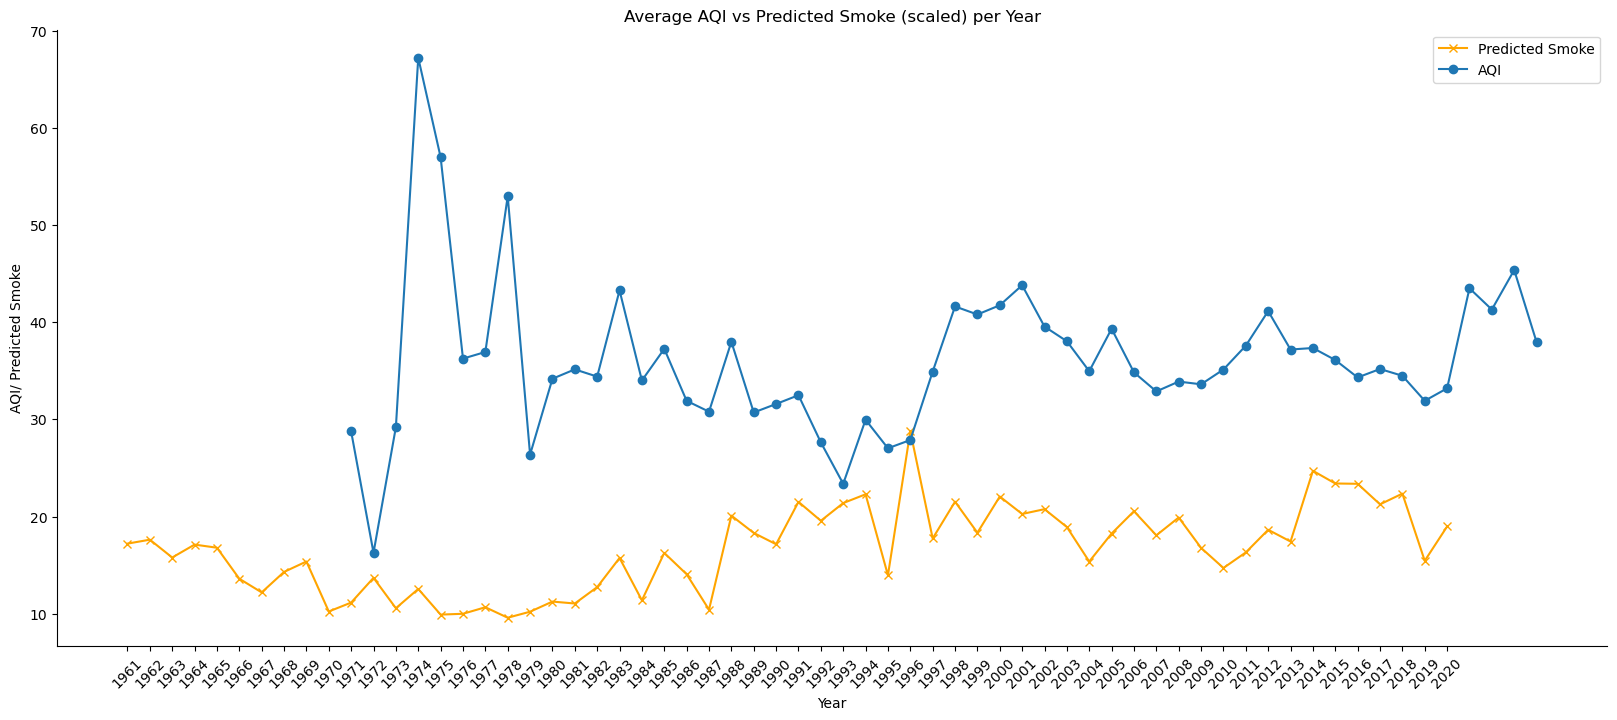

In [ ]:
plt.figure(figsize=(20, 8))

plt.plot(yearly_smoke_prediction["Year"], yearly_smoke_prediction["avg_smoke_scaled"], marker="x", linestyle="-", color="orange", label="Predicted Smoke")
plt.plot(avg_aqi_per_year["year"], avg_aqi_per_year["avg_aqi"], marker="o", linestyle="-", label="AQI")

plt.title("Average AQI vs Predicted Smoke (scaled) per Year")
plt.xlabel("Year")
plt.ylabel("AQI/ Predicted Smoke")

plt.grid(False)
plt.xticks(yearly_smoke_prediction["Year"], rotation=45)

plt.gca().spines["top"].set_visible(False)
plt.gca().spines["right"].set_visible(False)
plt.legend()

plt.savefig("../graphs/aqi_vs_predicted_smoke")
plt.show()